In [105]:
# import packages
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



In [106]:
# import the data
bikes = pd.read_csv('train.csv', index_col=0, parse_dates=True)
bikes.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [107]:
bikes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [108]:
bikes.notna().sum()
# the NaN shown are the related ot the missing data that we must fill in in th eend of each month!

season        10886
holiday       10886
workingday    10886
weather       10886
temp          10886
atemp         10886
humidity      10886
windspeed     10886
casual        10886
registered    10886
count         10886
dtype: int64

In [109]:
# In order to include the correlations from timestamp I will introduce new columns:
bikes['week'] = bikes.index.week
bikes['month'] = bikes.index.month
bikes['day'] = bikes.index.day
bikes['hour'] = bikes.index.hour
bikes['year'] = bikes.index.year
bikes['monthPERyear'] = bikes.index.month + (bikes['year']-2011)*12
bikes.head(2)
#bikes['day'].unique()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,week,month,day,hour,year,monthPERyear
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,52,1,1,0,2011,1
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,52,1,1,1,2011,1


In [110]:
bikes['countLog'] = np.log10(bikes['count'])

In [111]:
bikes = bikes.drop(columns=['registered','casual','temp','year','week','countLog'])

In [112]:
print(bikes.holiday.value_counts())
print(bikes['weather'].value_counts())
print(bikes.workingday.value_counts())

0    10575
1      311
Name: holiday, dtype: int64
1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64


In [113]:
# Change the only value weather =4 to 3 which is close!!
bikes.loc[bikes['weather'] == 4, 'weather'] = 3

In [114]:
# create X and y
X = pd.DataFrame(bikes)
X.drop(columns = ['count'],inplace=True)
y = bikes['count']

print(X.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

(10886, 11)
(10886,)


# Explore Data Analysis

1. $\color{yellow}{\text{Feature Selection }}$

- $\color{red}{\text{Correlation Coefficient}}$

<AxesSubplot:>

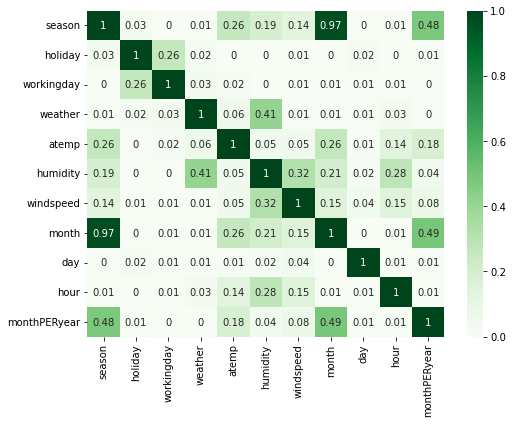

In [115]:
ax = plt.figure(figsize=(8,6))
pearsoncorr = X_train.corr(method='pearson')
sns.heatmap(abs(round(pearsoncorr,2)), xticklabels = pearsoncorr.columns, yticklabels=pearsoncorr.columns,
            cmap = 'Greens', annot=True)

- I should drop season,month, humidity

- $\color{red}{\text{VIF-Variance Inflation Factor}}$

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.api import add_constant 

In [117]:
X_vif = add_constant(X) 

In [118]:
pd.Series([variance_inflation_factor(X_vif.values, i) 
            for i in range(X_vif.shape[1])], 
            index=X_vif.columns)

const           43.749478
season          18.111725
holiday          1.082013
workingday       1.069828
weather          1.250116
atemp            1.114292
humidity         1.544071
windspeed        1.159999
month           18.576768
day              1.001922
hour             1.123291
monthPERyear     1.341396
dtype: float64

- $\color{red}{\text{Wrapper- Ordinary Least Squares}}$

In [119]:
from statsmodels.api import OLS, add_constant
m = OLS(y_train, add_constant(X_train)) #Adding constant column, mandatory for sm.OLS method
m_result = m.fit()
print(m_result.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     473.0
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        23:47:17   Log-Likelihood:                -52016.
No. Observations:                8164   AIC:                         1.041e+05
Df Residuals:                    8152   BIC:                         1.041e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -10.9301     10.358     -1.055   

In [120]:
m_result.rsquared_adj   # It penalizes for adding unnecessary features and allows a comparison of regression models
                        # R2 adjusted  adjust the statistic based on the number of independent variables

0.38876612015456047

#### Find the features with the lowest p-value , lower than 0.05

* In forward selection, we start with a null model and then start fitting the model with each individual feature one at a time and select the feature with the minimum p-value. 

In [121]:
# Create a list of features
forward_features = []

# Original features
feature_list = X_train.columns

In [122]:
possible_models = pd.DataFrame(columns=['features', 'p', 'adj_r2'])
# Run a linear regression separately on each of the features

while len(feature_list) > 0:
    forward_selection = pd.DataFrame(columns=['features', 'p', 'adj_r2'])
    for feature in feature_list:
        m_feature = OLS(y_train, X_train[forward_features + [feature]])
        result = m_feature.fit()
        forward_selection = forward_selection.append({
                                    'feature': feature
                                  , 'features': forward_features + [feature]
                                  , 'p': result.pvalues.loc[feature]
                                  , 'adj_r2': result.rsquared_adj}
                                  , ignore_index=True)

    if forward_selection.sort_values('p').iloc[0].p < 0.05:
        print(forward_selection.sort_values('p').iloc[0].features)
        best_feature = forward_selection.sort_values('p').iloc[0].feature
        forward_features.append(best_feature)
        feature_list = feature_list.drop(best_feature)
        best_model = forward_selection[forward_selection['feature']==best_feature]
        possible_models = possible_models.append(best_model, ignore_index=True)

    else:
        break

['season']
['season', 'atemp']
['season', 'atemp', 'hour']
['season', 'atemp', 'hour', 'humidity']
['season', 'atemp', 'hour', 'humidity', 'monthPERyear']
['season', 'atemp', 'hour', 'humidity', 'monthPERyear', 'windspeed']
['season', 'atemp', 'hour', 'humidity', 'monthPERyear', 'windspeed', 'month']


In [123]:
forward_features

['season', 'atemp', 'hour', 'humidity', 'monthPERyear', 'windspeed', 'month']

In [124]:
feature_list

Index(['holiday', 'workingday', 'weather', 'day'], dtype='object')

In [125]:
forward_selection

,features,p,adj_r2,feature
0,"[season, atemp, hour, humidity, monthPERyear, ...",0.392323,0.711074,holiday
1,"[season, atemp, hour, humidity, monthPERyear, ...",0.906683,0.711048,workingday
2,"[season, atemp, hour, humidity, monthPERyear, ...",0.098882,0.711144,weather
3,"[season, atemp, hour, humidity, monthPERyear, ...",0.506483,0.711064,day


In [126]:
possible_models

,features,p,adj_r2,feature
0,[season],0.000000e+00,0.502638,season
1,"[season, atemp]",0.000000e+00,0.598968,atemp
2,"[season, atemp, hour]",7.381960e-230,0.647248,hour
3,"[season, atemp, hour, humidity]",4.238471e-205,0.685358,humidity
4,"[season, atemp, hour, humidity, monthPERyear]",6.607238e-152,0.710811,monthPERyear
5,"[season, atemp, hour, humidity, monthPERyear, ...",1.939524e-02,0.710969,windspeed
6,"[season, atemp, hour, humidity, monthPERyear, ...",4.008953e-02,0.711083,month


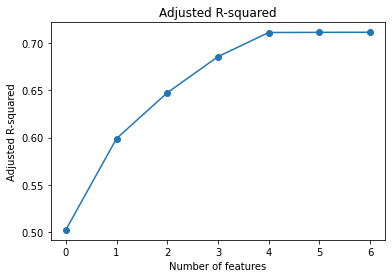

In [127]:
possible_models['adj_r2'].plot(marker="o")
plt.title('Adjusted R-squared')
plt.xlabel('Number of features')
plt.ylabel('Adjusted R-squared')
plt.show()

Feature 0: 222.493444
Feature 1: 0.372990
Feature 2: 1.425188
Feature 3: 135.716736
Feature 4: 1426.882276
Feature 5: 922.030906
Feature 6: 87.147658
Feature 7: 230.190913
Feature 8: 3.188644
Feature 9: 1612.546612
Feature 10: 845.834952


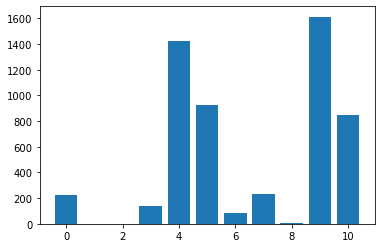

In [128]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
 
# feature selection
def select_features(X_train, y_train, X_test):
	# configure to select all features
	fs = SelectKBest(score_func=f_regression, k='all')
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs
 
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [129]:
X_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'atemp', 'humidity',
       'windspeed', 'month', 'day', 'hour', 'monthPERyear'],
      dtype='object')

1. $\color{yellow}{\text{Check feature dependence with groupby to see relation }}$

In [130]:
X_test.drop(columns = ['season','month','humidity'],inplace=True)
X_train.drop(columns = ['season','month','humidity'],inplace=True)

- # $\color{red}{\text{weather}}$

In [138]:
weather=bikes.groupby(['weather']).mean()
weather.head(1)

,season,holiday,workingday,atemp,humidity,windspeed,count,month,day,hour,monthPERyear
weather,,,,,,,,,,,
1,2.49708,0.028365,0.672831,23.994126,56.716769,12.892542,205.236791,6.479283,9.991379,11.733871,12.500973


<AxesSubplot:xlabel='weather', ylabel='count'>

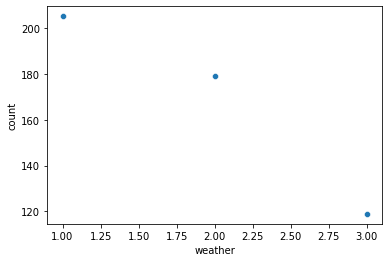

In [140]:
# check the statistics of the different datasets

sns.scatterplot(x = weather.index, y =weather['count'])

# $\color{green}{\text{Weather Result}}$
- make a OHE

- # $\color{red}{\text{temperature}}$

In [141]:
temp=bikes.groupby(['atemp']).mean()
temp.head(1)

,season,holiday,workingday,weather,humidity,windspeed,count,month,day,hour,monthPERyear
atemp,,,,,,,,,,,
0.76,1.0,0.0,1.0,1.0,34.0,19.0012,1.0,1.0,4.0,2.5,13.0


<AxesSubplot:xlabel='atemp', ylabel='count'>

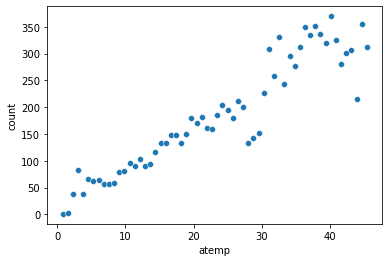

In [142]:
# check the statistics of the different datasets

sns.scatterplot(x = temp.index, y =temp['count'])

- - $\color{green}{\text{Fit a Poly Regression model }}$

In [143]:
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [144]:
# Fit the data with a polynomial to see the time evolution
def fit_with_poly(X, y, deg):
    poly = PolynomialFeatures(degree=deg,include_bias= True, interaction_only=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred_poly = lr.predict(X_poly)
    return y_pred_poly, X_poly


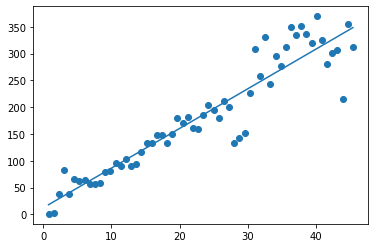

In [152]:
X = pd.DataFrame(temp.index) 
y =temp['count']
y_pred_poly, X_poly = fit_with_poly(X,y,1)
plt.scatter(X,y)
plt.plot(X,y_pred_poly)


# $\color{green}{\text{atemp Result}}$
- scale
- linear

 - # $\color{red}{\text{windspeed}}$

In [155]:
windspeed=bikes.groupby(['windspeed']).mean()
windspeed.head(1)

,season,holiday,workingday,weather,atemp,humidity,count,month,day,hour,monthPERyear
windspeed,,,,,,,,,,,
0.0,2.724296,0.031226,0.686976,1.370145,23.828111,68.134806,161.101295,7.191165,9.249048,9.898705,12.875857


<AxesSubplot:xlabel='windspeed', ylabel='count'>

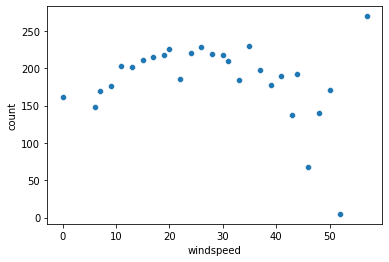

In [156]:
# check the statistics of the different datasets

sns.scatterplot(x = windspeed.index, y =windspeed['count'])

- - $\color{green}{\text{Fit a Poly Regression model }}$

In [157]:
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

In [158]:
# Fit the data with a polynomial to see the time evolution
def fit_with_poly(X, y, deg):
    poly = PolynomialFeatures(degree=deg,include_bias= True, interaction_only=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly,y)
    y_pred_poly = lr.predict(X_poly)
    return y_pred_poly, X_poly


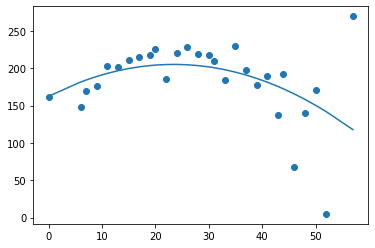

In [165]:
X = pd.DataFrame(windspeed.index) 
y =windspeed['count']
y_pred_poly, X_poly = fit_with_poly(X,y,2)
plt.scatter(X,y)
plt.plot(X,y_pred_poly)


# $\color{green}{\text{windspeed Result}}$
- scale
- 2nd degree poly